# Autoencoders como detector de anomalías
## Deep Learning. Máster en Ciencia de Datos
### Oriol Chacón Albero

En primer lugar necesitamos importar el dataset PHL-EC.csv con datos sobre planetas.

In [ ]:
from google.colab import files
 
 
uploaded = files.upload()

Saving PHL-EC.csv to PHL-EC.csv


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv('PHL-EC.csv')

# 1. Preprocesado de los datos
En primer lugar procesaremos los datos siguiendo los pasos explicados en el paper 'Postulating Exoplanetary Habitability via a Novel Anomaly Detection Method'. Tenemos 3875 planetas, pero no todas las variables están completas. Nos quedaremos solo con las variables que tengan al menos 3700 datos completos:

In [ ]:
nulls = []
for col in df.columns:
    #print(col)
    nulls.append((3875 - np.sum(df[col].isnull()))> 3700)

df.columns

Index(['P. Name', 'P. Name Kepler', 'P. Name KOI', 'P. Zone Class',
       'P. Mass Class', 'P. Composition Class', 'P. Atmosphere Class',
       'P. Habitable Class', 'P. Min Mass (EU)', 'P. Mass (EU)',
       'P. Max Mass (EU)', 'P. Radius (EU)', 'P. Density (EU)',
       'P. Gravity (EU)', 'P. Esc Vel (EU)', 'P. SFlux Min (EU)',
       'P. SFlux Mean (EU)', 'P. SFlux Max (EU)', 'P. Teq Min (K)',
       'P. Teq Mean (K)', 'P. Teq Max (K)', 'P. Ts Min (K)', 'P. Ts Mean (K)',
       'P. Ts Max (K)', 'P. Surf Press (EU)', 'P. Mag', 'P. Appar Size (deg)',
       'P. Period (days)', 'P. Sem Major Axis (AU)', 'P. Eccentricity',
       'P. Mean Distance (AU)', 'P. Inclination (deg)', 'P. Omega (deg)',
       'S. Name', 'S. Name HD', 'S. Name HIP', 'S. Constellation', 'S. Type',
       'S. Mass (SU)', 'S. Radius (SU)', 'S. Teff (K)', 'S. Luminosity (SU)',
       'S. [Fe/H]', 'S. Age (Gyrs)', 'S. Appar Mag', 'S. Distance (pc)',
       'S. RA (hrs)', 'S. DEC (deg)', 'S. Mag from Planet',
     

In [ ]:
df = df.loc[:,nulls]
df

,P. Name,P. Zone Class,P. Mass Class,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Mass (EU),P. Radius (EU),P. Density (EU),P. Gravity (EU),...,P. HZI,P. Int ESI,P. Surf ESI,P. ESI,S. HabCat,P. Habitable,P. Hab Moon,P. Confirmed,P. Disc. Method,P. Disc. Year
0,1RXS 1609 b,Cold,Jovian,gas,hydrogen-rich,non-habitable,4451.16,19.04,0.64,12.28,...,0.00,0,0,0.05,0,0,0,1,Imaging,2008
1,1SWASP J1407 b,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,10.94,4.86,53.12,...,0.02,0,0,0.07,0,0,0,1,Primary Transit,2012
2,2M 0103-55(AB) b,Cold,Jovian,gas,hydrogen-rich,non-habitable,4133.22,11.40,2.79,31.79,...,0.00,0,0,0.06,0,0,0,1,Imaging,2013
3,2M 0122-24 b,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,11.20,4.53,50.69,...,0.00,0,0,0.08,0,0,0,1,Imaging,2013
4,2M 0219-39 b,Cold,Jovian,gas,hydrogen-rich,non-habitable,4419.37,16.13,1.05,16.99,...,0.00,0,0,0.06,0,0,0,1,Imaging,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3870,YBP1194 b,Hot,Jovian,gas,metals-rich,non-habitable,108.10,7.97,0.21,1.70,...,0.15,0,0,0.16,0,0,0,1,Radial Velocity,2014
3871,YBP1514 b,Hot,Jovian,gas,metals-rich,non-habitable,127.18,8.34,0.22,1.83,...,0.15,0,0,0.15,0,0,0,1,Radial Velocity,2014
3872,YZ Cet b,Hot,Terran,rocky-iron,metals-rich,non-habitable,0.76,0.96,0.86,0.83,...,0.34,0,0,0.43,0,0,0,1,Radial Velocity,2017
3873,YZ Cet c,Hot,Terran,rocky-iron,metals-rich,non-habitable,0.99,1.04,0.88,0.91,...,0.36,0,0,0.53,0,0,0,1,Radial Velocity,2017


En la variable y guardaremos las etiquetas de los planetas: un 1 indicará que el planeta es habitable.

In [ ]:
y = df.loc[:,'P. Habitable Class']

for i in range(len(y)):
  if y[i] == 'non-habitable':
    y[i] = 0
  else:
    y[i] = 1

y.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


array([0, 1], dtype=object)

A continuación, los autores de la publicación consideran conveniente eliminar las variables categóricas. Sin embargo, algunas de éstas parecen importantes a la hora de determinar la habitabilidad de un planeta. Por ejemplo, no parece posible que un planeta gaseoso sea habitable. Por lo tanto, utilizaremos la función OrdinalEncoder de sklearn para codificar estas variables categóricas como numéricas.

In [ ]:
df['P. Mass Class'] = OrdinalEncoder().fit_transform(np.array(df['P. Mass Class']).reshape(-1, 1))
df['P. Zone Class'] = OrdinalEncoder().fit_transform(np.array(df['P. Zone Class']).reshape(-1, 1))
df['P. Composition Class'] = OrdinalEncoder().fit_transform(np.array(df['P. Composition Class']).reshape(-1, 1))
df['P. Atmosphere Class'] = OrdinalEncoder().fit_transform(np.array(df['P. Atmosphere Class']).reshape(-1, 1))

Eliminamos las variables con información irrelevante a la hora de determinar si el planeta es habitable o no:

In [ ]:
# variables irrelevantes
df = df.loc[:,df.columns != 'P. Name'] # nombre del planeta
df = df.loc[:,df.columns != 'P. Habitable Class'] # tipo de planeta habitable
df = df.loc[:,df.columns != 'S. Name']  # nombre de la estrella
df = df.loc[:,df.columns != 'P. Disc. Year'] # año de detección
df = df.loc[:,df.columns != 'S. Constellation'] # constelación
df = df.loc[:,df.columns != 'S. No. Planets'] # número de planetas
df = df.loc[:,df.columns != 'P. Disc. Method'] # método de detección
df = df.loc[:,df.columns != 'S. No. Planets HZ'] # número de planetas en la zona habitable

# variables categóricas
df = df.loc[:,df.columns != 'P. Confirmed']
df = df.loc[:, df.columns != 'S. Type']

Ahora podemos eliminar los registros con datos faltantes. Por un lado, imputar los valores faltantes no parece una solución realista, y por otro, conservamos la enorme mayoría de los datos (3632). 

In [ ]:
df = df.loc[:,df.columns != 'P. Habitable'] # eliminamos la variable habitabilidad
df = df.dropna()
y = y[df.index]

También debemos convertir los datos de SFlux a numérico.

In [ ]:
df["P. SFlux Min (EU)"] = pd.to_numeric(df["P. SFlux Min (EU)"],errors='coerce')
df["P. SFlux Mean (EU)"] = pd.to_numeric(df["P. SFlux Mean (EU)"],errors='coerce')
df["P. SFlux Max (EU)"] = pd.to_numeric(df["P. SFlux Max (EU)"],errors='coerce')

En mi primera aproximación al problema, el preprocesado de los datos terminaba aquí. Sin embargo, los resultados no eran demasiado prometedores: muchos planetas no habitables eran considerados como habitables y obteníamos una métrica de precisión inferior al 20%. Por lo tanto, aunque quizá no es la aproximación que se pedía para este problema, decidí seleccionar de antemano aquellas variables más importantes a la hora de determinar si un planeta es habitable o no mediante un random forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
y=y.astype('int')
names = df.columns
df = MinMaxScaler().fit_transform(df)
clf = RandomForestClassifier()

clf.fit(df, y)


RandomForestClassifier()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41],
 <a list of 42 Text major ticklabel objects>)

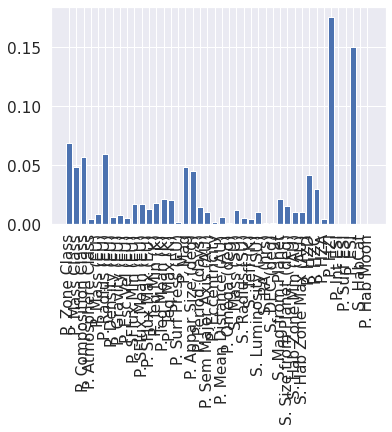

In [ ]:
plt.bar(names,clf.feature_importances_)
plt.xticks(rotation = 90)

In [ ]:
print((clf.feature_importances_>0.025)*names)
df = df[['P. Zone Class', 'P. Mass Class', 'P. Composition Class', 'P. Radius (EU)','P. Teq Min (K)','P. Mag',
       'P. Appar Size (deg)', 'S. Mag from Planet','P. HZD', 'P. HZC','P. HZI','P. ESI']]

Index(['P. Zone Class', 'P. Mass Class', 'P. Composition Class', '', '',
       'P. Radius (EU)', '', '', '', '', '', '', '', '', '', '', 'P. Mag',
       'P. Appar Size (deg)', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', 'P. HZD', 'P. HZC', '', 'P. HZI', '', '', 'P. ESI', '', ''],
      dtype='object')


# 2. PCA + Autoencoder
Una vez preprocesado el dataset procedemos a utilizar un autoencoder como detector de anomalías. Asumimos que los planetas habitables son una anomalía dentro del conjunto de planetas no habitables. Por lo tanto, podemos construir un autoencoder y entrenarlo únicamente con datos de planetas no habitables de forma que al intentar reconstruir datos de planetas habitables, el error de reconstrucción será mayor.

En este primer caso no necesitamos revisar la correlación entre las variables, ya que la PCA nos proporcionará las 10 variables descorrelacionadas más representativas de los datos:

In [ ]:
df = MinMaxScaler().fit_transform(df)
data = PCA(n_components = 10).fit_transform(df)

In [ ]:
x_train = data[y == 0,:]

In [ ]:
inp = keras.layers.Input(shape = (10,))
codif = keras.layers.Dense(32, activation = 'relu')(inp)
codif = keras.layers.Dropout(0.2)(codif)
codif = keras.layers.Dense(16, activation = 'relu')(codif)
codif = keras.layers.Dense(5, activation = 'relu')(codif)
decod = keras.layers.Dense(16, activation = 'relu')(codif)
codif = keras.layers.Dropout(0.2)(decod)
decod = keras.layers.Dense(32, activation = 'relu')(decod)
decod = keras.layers.Dense(10, activation = tf.nn.tanh)(decod)

autoencoderAD = keras.Model(inp, decod)
autoencoderAD.compile(optimizer = 'adam', loss = 'mse')

history = autoencoderAD.fit(x_train, x_train, epochs = 100)

Epoch 1/100
112/112 [==============================] - 1s 2ms/step - loss: 0.0206
Epoch 2/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 3/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 4/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 5/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 6/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 7/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 8/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 9/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 10/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 11/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 12/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 13/100


In [ ]:
x_pred = autoencoderAD.predict(data)
res = pd.DataFrame(y)
res['err_test'] = np.mean(np.abs(data - x_pred)**2, axis = tuple(range(1, data.ndim)))

res.index = range(3632) # reseteamos los índices para poder comparar los resultados

Un posible criterio para fijar el umbral sería considerar que el error de reconstrucción se distribuye de forma gaussiana. Por lo tanto, un dato anómalo sería aquel que se aleje más de 3 sigmas del error medio (donde se encuentran el 99% de los datos):

In [ ]:
hab = []
fn_tresh = np.mean(res['err_test']) + 3*np.std(res['err_test'])
for err in res['err_test']:
  if err > fn_tresh:
    hab.append(1)
  else:
    hab.append(0)

res.index = range(3632)
acc = np.sum(hab == res['P. Habitable Class'])/data.shape[0]
print('El porcentaje de acierto comparado con las etiquetas es: ',acc)

El porcentaje de acierto comparado con las etiquetas es:  0.9920154185022027


Observamos que el accuracy no es una buena métrica en este caso ya que las clases están muy desbalanceadas. A partir de ahora usaremos el precision. Efectivamente, se trata de una métrica acertada ya que en la vida real los planetas no están etiquetados, y por lo tanto vale la pena sacrificar algunos posibles planetas habitables, si con eso reducimos el conjunto y augmentamos la probabilidad de acertar (el caso contrario sería que nuestro clasificador acertara todos los 55 planetas habitables pero incluyera otros 700 falsos panetas habitables, lo cual es contraproducente).

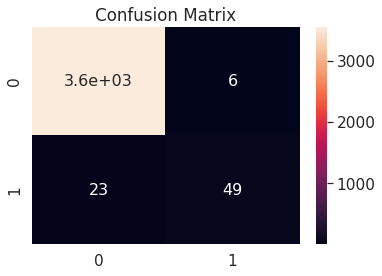

In [ ]:
hab = np.array(hab)
TP = np.sum(np.logical_and(hab == 1, res['P. Habitable Class'] == 1))
TN = np.sum(np.logical_and(hab == 0, res['P. Habitable Class'] == 0))
FN = np.sum(np.logical_and(hab == 0, res['P. Habitable Class'] == 1))
FP = np.sum(np.logical_and(hab == 1, res['P. Habitable Class'] == 0))

M = [[TN, FN],
     [FP, TP]]
df_cm = pd.DataFrame(M, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}).set(title='Confusion Matrix') # font size

plt.show()

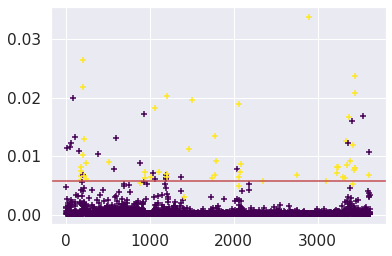

In [ ]:
%matplotlib inline

plt.figure()
plt.scatter(range(len(res['err_test'])), res['err_test'], marker = '+', c = res['P. Habitable Class'], cmap='viridis')
plt.axhline(y=fn_tresh, color='r', linestyle='-')


In [ ]:
print('Obtenemos una precission de: ',TP/(TP + FP))


Obtenemos una precission de:  0.6805555555555556


# 3. Autoencoder de RD
Ahora utilizaremos un autoencoder como método de reducción de la dimensionalidad en lugar de PCA. Por lo tanto, ahora si que deberemos eliminar las variables altamente correlacionadas:


In [ ]:
# Create correlation matrix
df = pd.DataFrame(df)
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
df = df.drop(df.columns[to_drop], axis = 1)

In [ ]:
df = np.array(df)
x_train = df[y == 0,:]

In [ ]:
inp = keras.layers.Input(shape = (df.shape[1],))
codif = keras.layers.Dense(16, activation = 'relu')(inp)
codif = keras.layers.Dropout(0.2)(codif)
codif2 = keras.layers.Dense(10, activation = 'relu')(codif)
codif3 = keras.layers.Dense(16, activation = 'relu')(codif2)
codif3 = keras.layers.Dropout(0.2)(codif3)
decod = keras.layers.Dense(df.shape[1], activation = tf.nn.tanh)(codif3)

autoencoder2 = keras.Model(inp, decod)
autoencoder2.compile('adam', 'mse')
history = autoencoder2.fit(x_train, x_train, epochs = 100)

Epoch 1/100
112/112 [==============================] - 1s 2ms/step - loss: 0.0752
Epoch 2/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 3/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 4/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 5/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 7/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 8/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 9/100
112/112 [==============================] - 0s 1ms/step - loss: 0.0087
Epoch 10/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 11/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 12/100
112/112 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 13/100


In [ ]:
autoencoderRD = keras.Model(inp, codif2)
autoencoderRD.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_42 (Dense)            (None, 16)                128       
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_43 (Dense)            (None, 10)                170       
                                                                 
Total params: 298
Trainable params: 298
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_trainRD = autoencoderRD.predict(x_train)
history = autoencoderAD.fit(x_trainRD, x_trainRD, epochs = 100)

Epoch 1/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 2/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 3/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 4/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 5/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 6/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 7/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 8/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 9/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 10/100
112/112 [==============================] - 0s 2ms/step - loss: 9.5684e-04
Epoch 11/100
112/112 [==============================] - 0s 2ms/step - loss: 9.0091e-04
Epoch 12/100
112/112 [==============================] - 0s 2ms/step - loss: 9.2810e-04
E

In [ ]:
xRD = autoencoderRD.predict(df)
x_pred2 = autoencoderAD.predict(xRD)
res2 = pd.DataFrame(y)
res2['err_test'] = np.mean(np.abs(xRD - x_pred2)**2, axis = tuple(range(1, xRD.ndim)))

res2.index = range(3632) # reseteamos los índices para poder comparar los resultados

In [ ]:
hab = []
fn_tresh = np.mean(res2['err_test']) + 3*np.std(res2['err_test'])

for err in res2['err_test']:
  if err > fn_tresh:
    hab.append(1)
  else:
    hab.append(0)

acc = np.sum(hab == res2['P. Habitable Class'])/df.shape[0]
print('El porcentaje de acierto comparado con las etiquetas es: ',acc)

El porcentaje de acierto comparado con las etiquetas es:  0.998898678414097


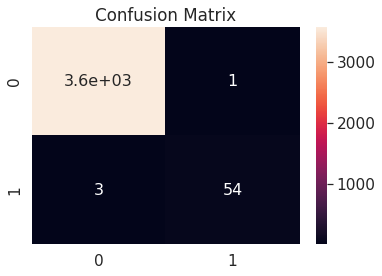

In [ ]:
hab = np.array(hab)
TP = np.sum(np.logical_and(hab == 1, res2['P. Habitable Class'] == 1))
TN = np.sum(np.logical_and(hab == 0, res2['P. Habitable Class'] == 0))
FN = np.sum(np.logical_and(hab == 0, res2['P. Habitable Class'] == 1))
FP = np.sum(np.logical_and(hab == 1, res2['P. Habitable Class'] == 0))

M = [[TN, FN],
     [FP, TP]]
df_cm = pd.DataFrame(M, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}).set(title='Confusion Matrix') # font size

plt.show()

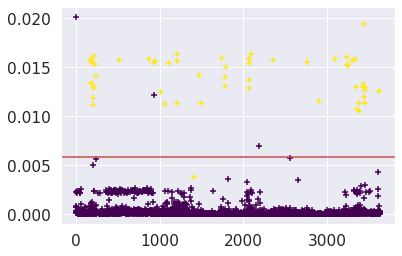

In [ ]:
%matplotlib inline

plt.figure()
plt.scatter(range(len(res2['err_test'])), res2['err_test'], marker = '+', c = res2['P. Habitable Class'], cmap='viridis')
plt.axhline(y=fn_tresh, color='r', linestyle='-')

En este caso los resultados son mucho mejores que en el anterior.

In [ ]:
print('Obtenemos una precission de: ',TP/(TP + FP))

Obtenemos una precission de:  0.9473684210526315


# 4. Autoencoder únicamente
Finalmente, nos han propuesto un único autoencoder como detector de anomalías capaz de trabajar con el dataset entero:

In [ ]:
inp = keras.layers.Input(shape = (df.shape[1],))
codif = keras.layers.Dense(15, activation = 'relu')(inp)
codif = keras.layers.Dropout(0.2)(codif)
codif2 = keras.layers.Dense(8, activation = 'relu')(codif)
codif2 = keras.layers.Dropout(0.2)(codif2)
codif3 = keras.layers.Dense(3, activation = 'relu')(codif2)
codif3 = keras.layers.Dropout(0.2)(codif3)
codif4 = keras.layers.Dense(8, activation = 'relu')(codif3)
codif4 = keras.layers.Dropout(0.2)(codif4)
codif5 = keras.layers.Dense(15, activation = 'relu')(codif4)
decod = keras.layers.Dense(df.shape[1], activation = tf.nn.tanh)(codif5)

autoencoderTO = keras.Model(inp, decod)
autoencoderTO.compile(optimizer = 'adam', loss = 'mse')

history = autoencoderTO.fit(x_train, x_train, epochs = 100)

Epoch 1/100
112/112 [==============================] - 2s 3ms/step - loss: 0.0583
Epoch 2/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0321
Epoch 3/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 4/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 5/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 6/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 7/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 8/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 9/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 10/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 11/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 12/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 13/100


In [ ]:
x_pred3 = autoencoderTO.predict(df)
res3 = pd.DataFrame(y)
res3['err_test'] = np.mean(np.abs(df - x_pred3)**2, axis = tuple(range(1, df.ndim)))

res3.index = range(3632) # reseteamos los índices para poder comparar los resultados

In [ ]:
hab = []
fn_tresh = np.mean(res3['err_test']) + 3*np.std(res3['err_test'])

for err in res3['err_test']:
  if err > fn_tresh:
    hab.append(1)
  else:
    hab.append(0)


acc = np.sum(hab == res3['P. Habitable Class'])/df.shape[0]
print('El porcentaje de acierto comparado con las etiquetas es: ',acc)

El porcentaje de acierto comparado con las etiquetas es:  0.9909140969162996


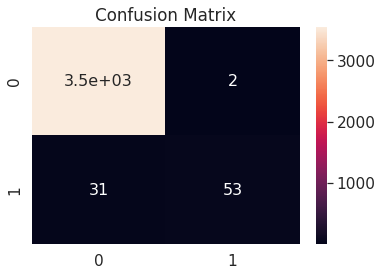

In [ ]:
hab = np.array(hab)
TP = np.sum(np.logical_and(hab == 1, res3['P. Habitable Class'] == 1))
TN = np.sum(np.logical_and(hab == 0, res3['P. Habitable Class'] == 0))
FN = np.sum(np.logical_and(hab == 0, res3['P. Habitable Class'] == 1))
FP = np.sum(np.logical_and(hab == 1, res3['P. Habitable Class'] == 0))

M = [[TN, FN],
     [FP, TP]]
df_cm = pd.DataFrame(M, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}).set(title='Confusion Matrix') # font size

plt.show()

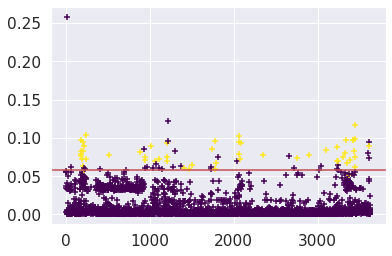

In [ ]:
%matplotlib inline

plt.figure()
plt.scatter(range(len(res3['err_test'])), res3['err_test'], marker = '+', c = res3['P. Habitable Class'], cmap='viridis')
plt.axhline(y=fn_tresh, color='r', linestyle='-')


In [ ]:
print('Obtenemos una precission de: ',TP/(TP + FP))

Obtenemos una precission de:  0.6309523809523809


# 5. Conclusiones
En los tres casos hemos sido capaces de construir un clasificador capaz de clasificar los planetas en función de su habitabilidad. Sin embargo, los resultados de precisión entorno al 65% en el primer y tercer apartados, aunque bastante buenos, implican que para un nuevo planeta descubierto y clasificado como habitable, existe una probabilidad significativa de ser un falso positivo. El segundo clasificador sin embargo obtiene resultados muy buenos.